In [113]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import pathlib
import numpy as np
import pandas as pd

seed_ = 42

dim = 16
directory = pathlib.Path("../events/MG3")

df_3b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbj.h5")
df_bg4b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbb_large.h5")
df_hh4b = pd.read_hdf(directory / "dataframes" / "symmetrized_HH4b.h5")

df_3b["signal"] = False
df_bg4b["signal"] = False
df_hh4b["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_hh4b))

# shuffle the data
df_3b = df_3b.sample(frac=1, random_state=seed_).reset_index(drop=True)
df_bg4b = df_bg4b.sample(frac=1, random_state=seed_).reset_index(drop=True)
df_hh4b = df_hh4b.sample(frac=1, random_state=seed_).reset_index(drop=True)

3b-jet events:  275508
4b-jet events:  382108
HH4b-jet events:  28656


Seed set to 42


********************************************
Signal ratio: 0.05
********************************************


/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


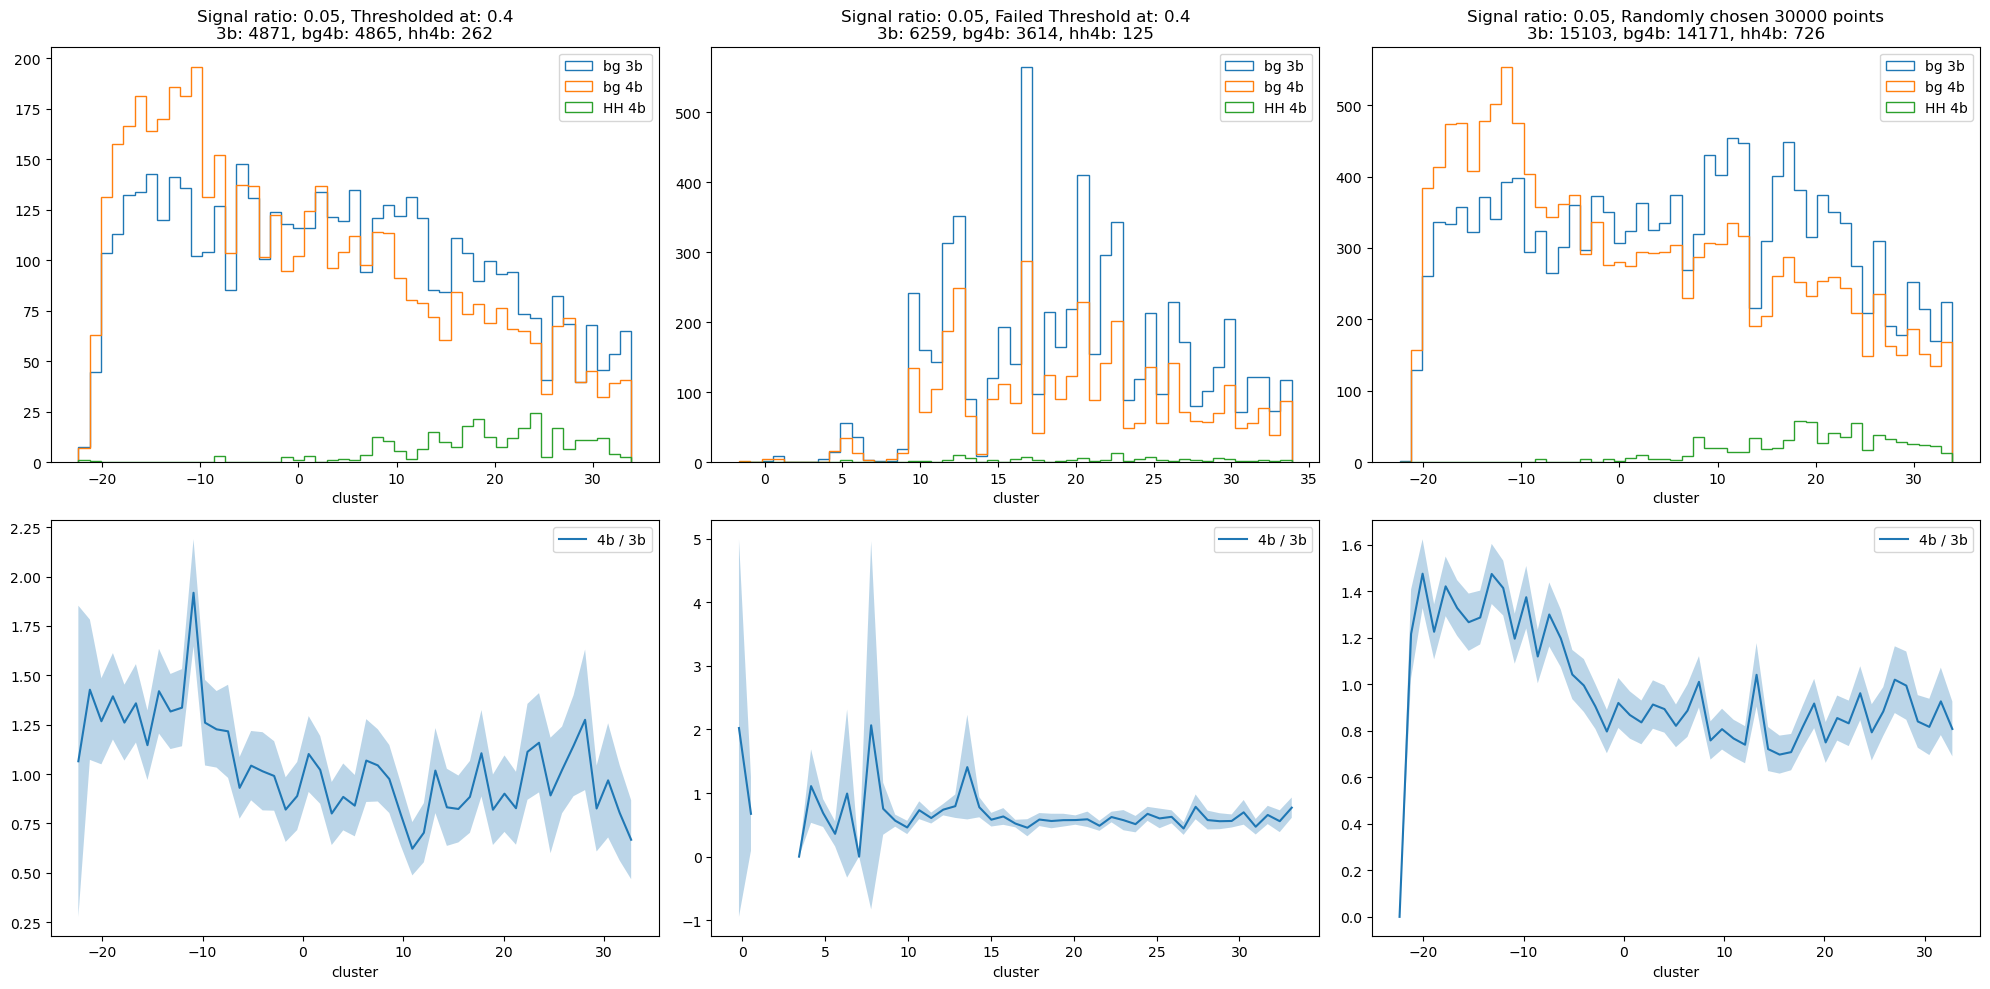

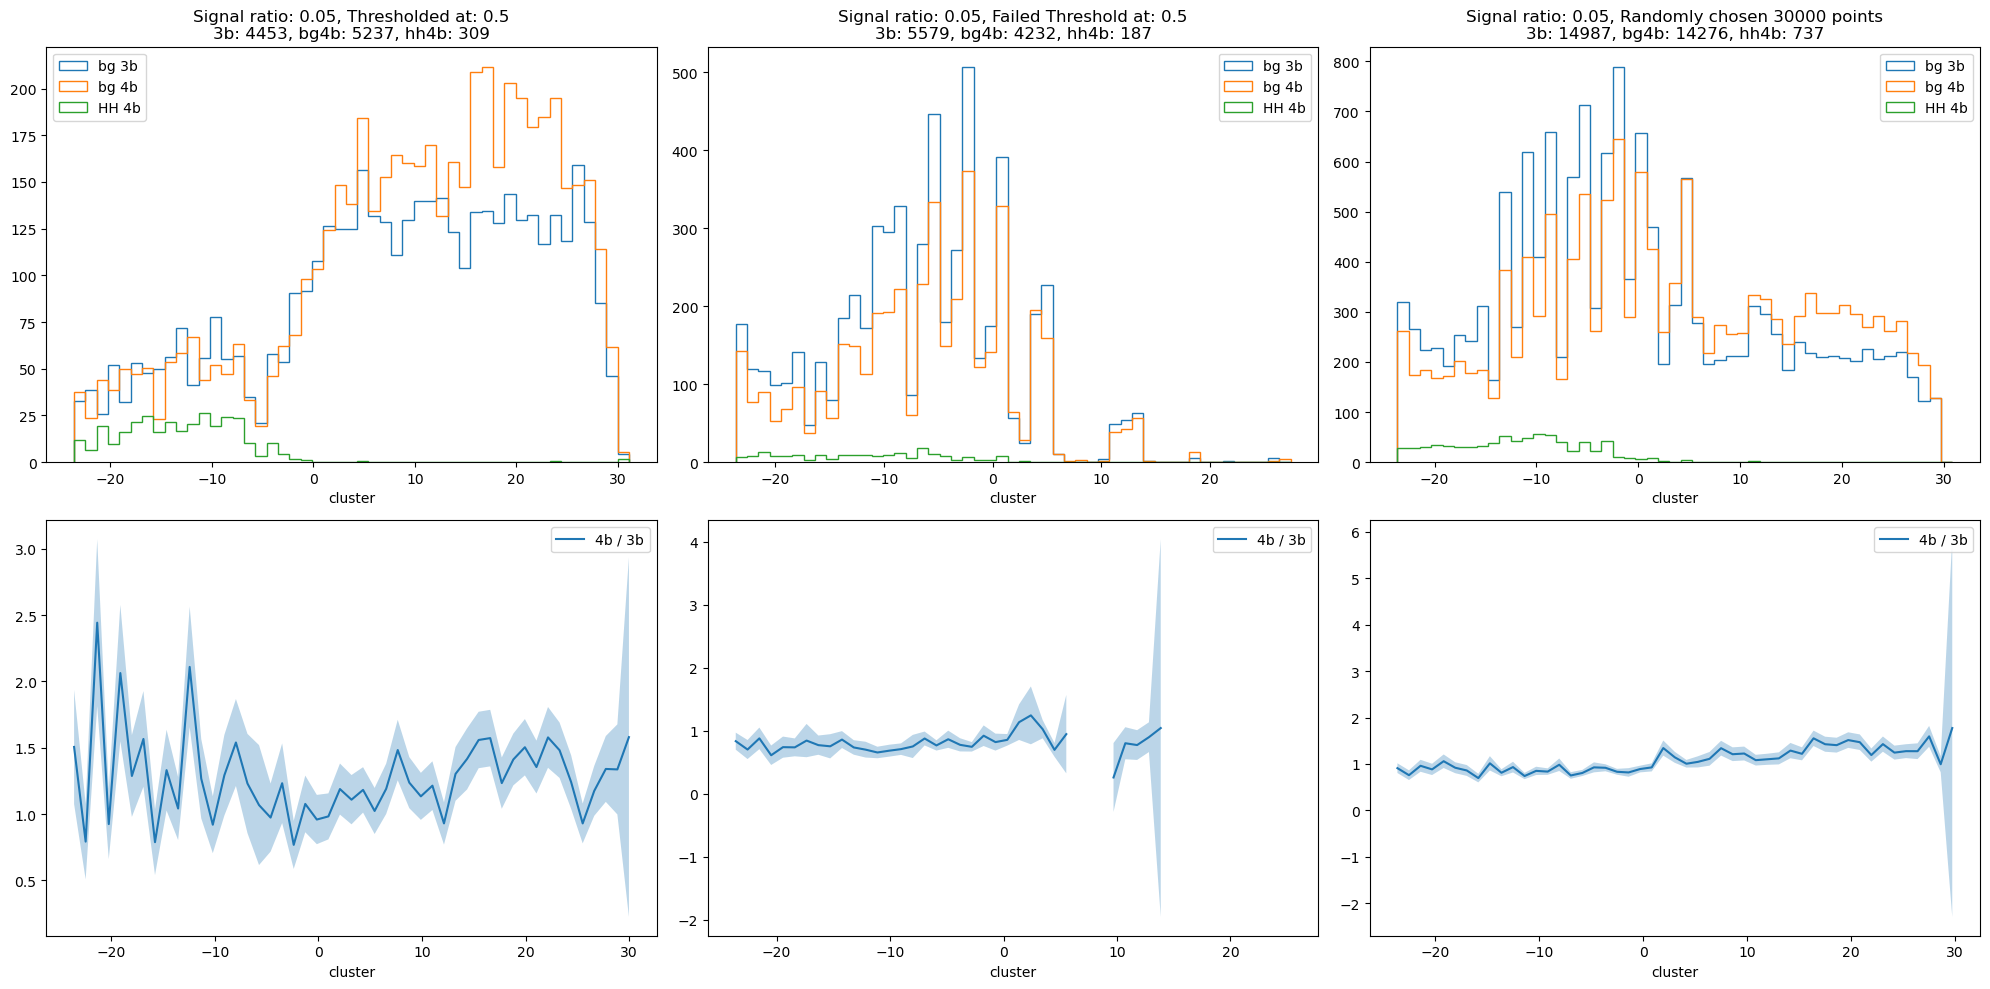

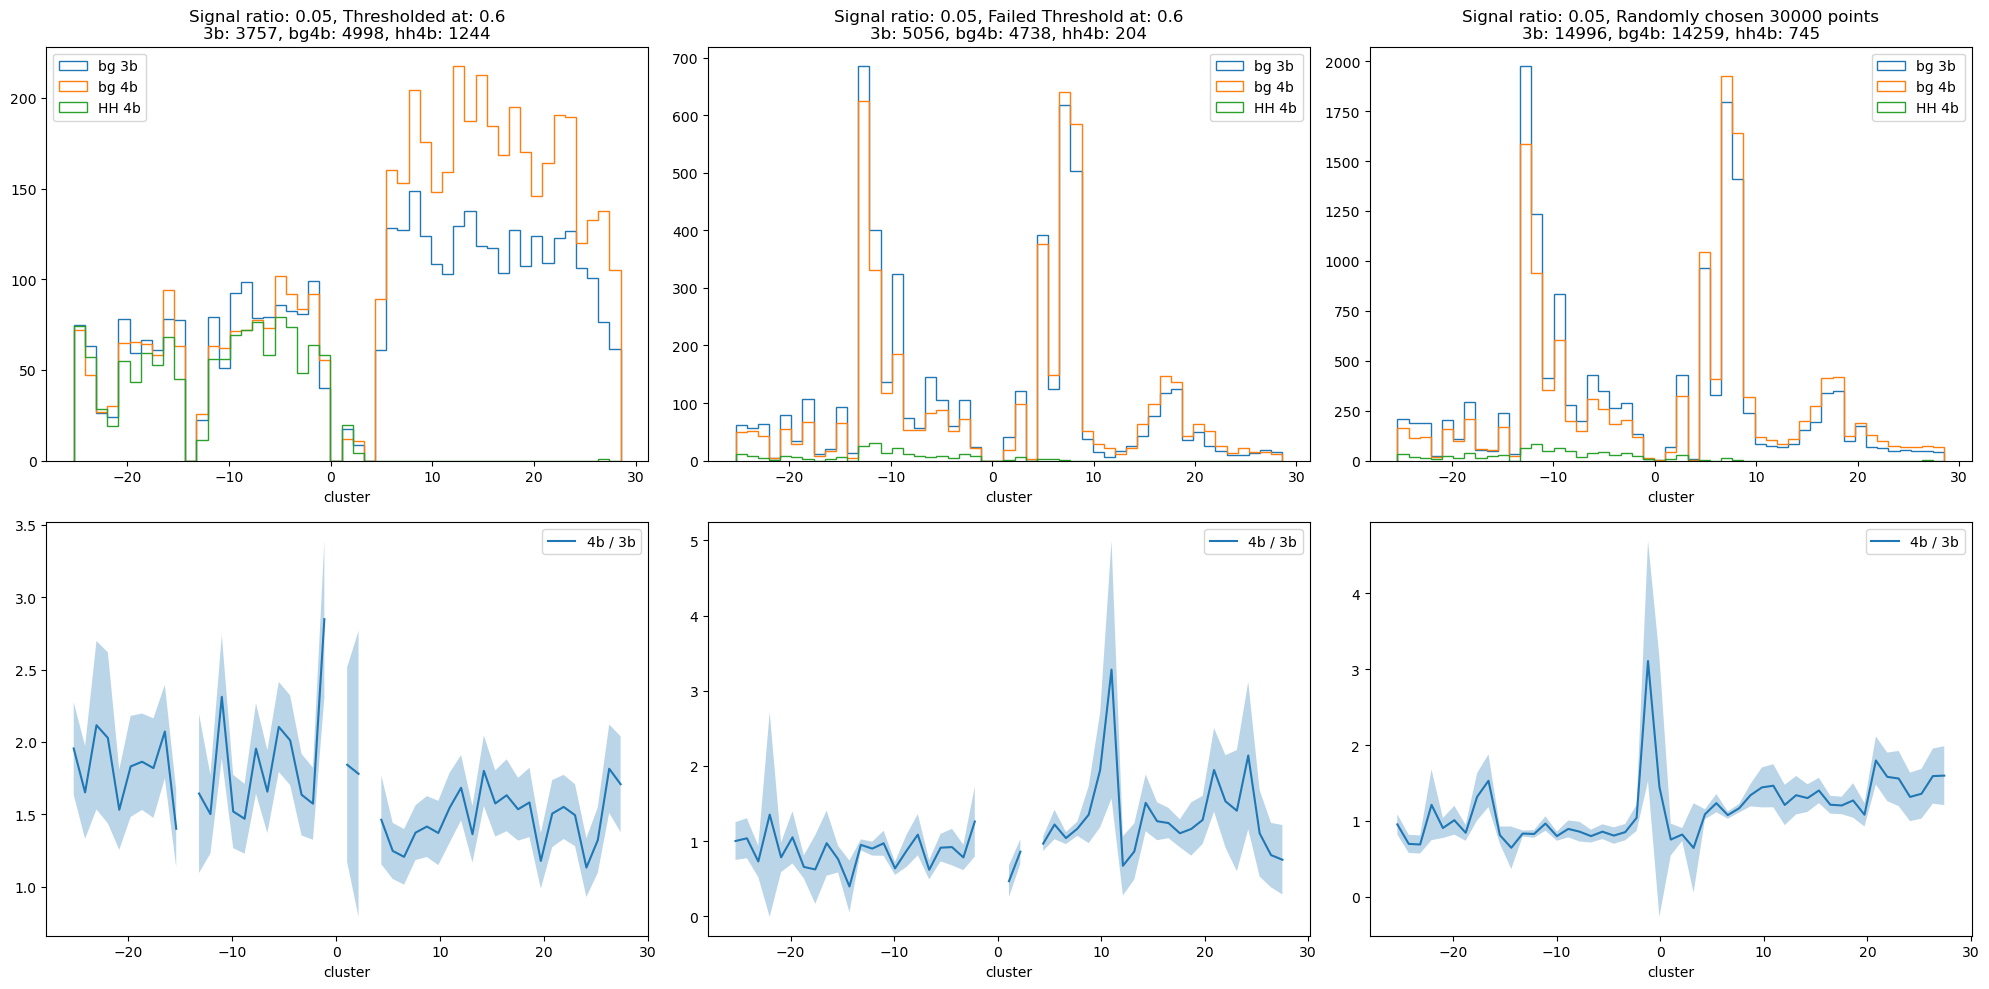

In [3]:
import pytorch_lightning as pl
from torch.utils.data import TensorDataset
from fvt_classifier import FvTClassifier
from fvt_representations import get_fvt_reprs
from plots import plot_cluster, plot_cluster_1d
import matplotlib.pyplot as plt

np.random.seed(seed_)

features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

pl.seed_everything(seed_)
np.random.seed(seed_)

test_ratio = 0.5
n_3b = 250000
n_all4b = 250000
# signal_ratio = 0.05

for signal_ratio in [0.05]:

    print("********************************************")
    print(f"Signal ratio: {signal_ratio}")
    print("********************************************")


    n_3b_train = int(n_3b * (1 - test_ratio))
    n_all4b_train = int(n_all4b * (1 - test_ratio))
    n_bg4b_train = n_all4b_train - int(n_all4b_train * signal_ratio)
    n_hh4b_train = int(n_all4b_train * signal_ratio)


    df_3b_train = df_3b.iloc[:n_3b_train]
    df_bg4b_train = df_bg4b.iloc[:n_bg4b_train]
    df_hh4b_train = df_hh4b.iloc[:n_hh4b_train]
    # reweight to match signal_ratio
    df_hh4b_train.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                                np.sum(df_bg4b_train["weight"]) / np.sum(df_hh4b_train["weight"])) * df_hh4b_train["weight"]
    df_train = pd.concat([df_3b_train, df_bg4b_train, df_hh4b_train])
    # shuffle the data
    df_train = df_train.sample(frac=1, random_state=seed_).reset_index(drop=True)

    n_3b_test = n_3b - n_3b_train
    n_all4b_test = n_all4b - n_all4b_train
    n_bg4b_test = n_all4b_test - int(n_all4b_test * signal_ratio)
    n_hh4b_test = int(n_all4b_test * signal_ratio)

    df_3b_test = df_3b.iloc[n_3b_train:n_3b_train+n_3b_test]
    df_bg4b_test = df_bg4b.iloc[n_bg4b_train:n_bg4b_train+n_bg4b_test]
    df_hh4b_test = df_hh4b.iloc[n_hh4b_train:n_hh4b_train+n_hh4b_test]
    df_hh4b_test.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                                np.sum(df_bg4b_test["weight"]) / np.sum(df_hh4b_test["weight"])) * df_hh4b_test["weight"]
    df_test = pd.concat([df_3b_test, df_bg4b_test, df_hh4b_test])
    df_test = df_test.sample(frac=1, random_state=seed_).reset_index(drop=True)

    # reduce number of 4b samples to 1/8
    # print("4b ratio: ", df_train.loc[df_train["fourTag"], "weight"].sum() / df_train["weight"].sum())
    # print("Signal ratio: ", df_train.loc[df_train["signal"], "weight"].sum() / df_train.loc[df_train["fourTag"], "weight"].sum())

    # For ghostbatch, let len(train_indices) be a multiple of 32
    split_at = 1024 * (int((2/3) * df_train.index.size) // 1024)
    end_at = 1024 * (df_train.index.size // 1024)

    X_train = torch.tensor(df_train[features].values, dtype=torch.float32)[:split_at]
    w_train = torch.tensor(df_train["weight"].values, dtype=torch.float32)[:split_at]
    y_train = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[:split_at]
    is_signal_train = torch.tensor(df_train["signal"].values, dtype=torch.long)[:split_at]

    X_val = torch.tensor(df_train[features].values, dtype=torch.float32)[split_at:end_at]
    w_val = torch.tensor(df_train["weight"].values, dtype=torch.float32)[split_at:end_at]
    y_val = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[split_at:end_at]
    is_signal_val = torch.tensor(df_train["signal"].values, dtype=torch.long)[split_at:end_at]

    train_dataset = TensorDataset(X_train, y_train, w_train)
    val_dataset = TensorDataset(X_val, y_val, w_val)


    num_classes = 2
    dim_input_jet_features = 4
    dim_dijet_features = 6
    dim_quadjet_features = 6
    max_epochs = 30
    run_name = "_".join(["fvt_classifier_toy_signal_ratio", 
                        f"signal_ratio={signal_ratio}", 
                        f"dijet={dim_dijet_features}", 
                        f"quadjet={dim_quadjet_features}", 
                        f"n_3b={n_3b}",
                        f"n_all4b={n_all4b}",])
    lr = 1e-3



    end_at = 1024 * (df_test.index.size // 1024)

    X_test = torch.tensor(df_test[features].values[:end_at], dtype=torch.float32)
    w_test = torch.tensor(df_test["weight"].values[:end_at], dtype=torch.float32)
    y_test = torch.tensor(df_test["fourTag"].values[:end_at], dtype=torch.long)
    is_signal_test = torch.tensor(df_test["signal"].values[:end_at], dtype=torch.long)

    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
    q_repr_test, view_scores_test = get_fvt_reprs(X_test, fvt_model)
    labels_4b_test = y_test.cpu().numpy()
    probs_4b_test = fvt_model.predict(X_test)[:, 1].cpu().numpy()
    weights_test = w_test.cpu().numpy()
    is_signal_test = is_signal_test.cpu().numpy()
    is_3b_test = labels_4b_test == 0
    is_4b_test = labels_4b_test == 1
    is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
    is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)

    # umap
    
    import umap

    n_components = 1
    umap_reducer = umap.UMAP(n_components=n_components, 
                            #  random_state=seed_, 
                             verbose=False)
    reducer = umap_reducer
    
    # probs_4b_threshold = 0.6

    # for probs_4b_threshold in [0.4, 0.5, 0.6]:
    for probs_4b_threshold in [0.4, 0.5, 0.6]:
        # print(f"Threshold: {probs_4b_threshold}")

        probs_4b_exceeded = probs_4b_test > probs_4b_threshold
        n_exceeded = np.sum(probs_4b_exceeded)

        n_points = min(np.sum(probs_4b_exceeded), 10000)
        n_cluster_3b = np.sum(is_3b_test & probs_4b_exceeded)
        n_cluster_bg4b = np.sum(is_bg4b_test & probs_4b_exceeded)
        n_cluster_hh4b = np.sum(is_hh4b_test & probs_4b_exceeded)

        n_cluster_3b = int((n_points / n_exceeded) * n_cluster_3b)
        n_cluster_bg4b = int((n_points / n_exceeded) * n_cluster_bg4b)
        n_cluster_hh4b = int((n_points / n_exceeded) * n_cluster_hh4b)

        np.random.seed(seed_)
        # cluster_samples = np.random.choice(np.where(probs_4b_exceeded)[0], n_points, replace=False)
        # cluster_samples = np.random.choice(np.where(~probs_4b_exceeded)[0], n_points, replace=False)
        # cluster_samples = np.random.choice(np.where(probs_4b_exceeded & (~is_signal_test))[0], n_points, replace=False)

        cluster_samples = np.concatenate([
            np.random.choice(np.where(is_3b_test & probs_4b_exceeded)[0], n_cluster_3b, replace=False),
            np.random.choice(np.where(is_bg4b_test & probs_4b_exceeded)[0], n_cluster_bg4b, replace=False),
            np.random.choice(np.where(is_hh4b_test & probs_4b_exceeded)[0], n_cluster_hh4b, replace=False),
        ])
        q_repr_cluster = q_repr_test[cluster_samples]
        is_3b_cluster = labels_4b_test[cluster_samples] == 0
        is_bg4b_cluster = (labels_4b_test[cluster_samples] == 1) & (is_signal_test[cluster_samples] == 0)
        is_hh4b_cluster = is_signal_test[cluster_samples] == 1
        weights_cluster = weights_test[cluster_samples]
        view_scores_cluster = view_scores_test[cluster_samples]

        # print number of points in each class
        # print("Thresholded samples")
        # print("3b: ", np.sum(is_3b_cluster))
        # print("bg4b: ", np.sum(is_bg4b_cluster))
        # print("hh4b: ", np.sum(is_hh4b_cluster))

        # umap_embed_cluster = umap_reducer.fit_transform(q_repr_cluster.reshape(-1, 3*dim_quadjet_features))

        # plot_cluster(umap_embed_cluster, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)

        att_q_repr_cluster = (q_repr_cluster @ view_scores_cluster[:, :, None]).reshape(-1, dim_quadjet_features)
        umap_embed_cluster = reducer.fit_transform(att_q_repr_cluster)

        # plot_cluster(umap_embed_cluster, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components, 
        #              title=f"Signal ratio: {signal_ratio}, Threshold: {probs_4b_threshold}")

        # # failed samples
        # print("Failed samples")
        # print("3b: ", np.sum(is_3b_test & ~probs_4b_exceeded))
        # print("bg4b: ", np.sum(is_bg4b_test & ~probs_4b_exceeded))
        # print("hh4b: ", np.sum(is_hh4b_test & ~probs_4b_exceeded))

        n_failed = np.sum(~probs_4b_exceeded)
        n_points = min(np.sum(~probs_4b_exceeded), 10000)
        n_failed_3b = np.sum(is_3b_test & ~probs_4b_exceeded)
        n_failed_bg4b = np.sum(is_bg4b_test & ~probs_4b_exceeded)
        n_failed_hh4b = np.sum(is_hh4b_test & ~probs_4b_exceeded)

        n_failed_3b = int((n_points / n_failed) * n_failed_3b)
        n_failed_bg4b = int((n_points / n_failed) * n_failed_bg4b)
        n_failed_hh4b = int((n_points / n_failed) * n_failed_hh4b)

        thrs_fail_samples = np.concatenate([
            np.random.choice(np.where(is_3b_test & ~probs_4b_exceeded)[0], n_failed_3b, replace=False),
            np.random.choice(np.where(is_bg4b_test & ~probs_4b_exceeded)[0], n_failed_bg4b, replace=False),
            np.random.choice(np.where(is_hh4b_test & ~probs_4b_exceeded)[0], n_failed_hh4b, replace=False),
        ])

        q_repr_fail = q_repr_test[thrs_fail_samples]
        is_3b_fail = labels_4b_test[thrs_fail_samples] == 0
        is_bg4b_fail = (labels_4b_test[thrs_fail_samples] == 1) & (is_signal_test[thrs_fail_samples] == 0)
        is_hh4b_fail = is_signal_test[thrs_fail_samples] == 1
        weights_fail = weights_test[thrs_fail_samples]
        view_scores_fail = view_scores_test[thrs_fail_samples]

        att_q_repr_fail = (q_repr_fail @ view_scores_fail[:, :, None]).reshape(-1, dim_quadjet_features)
        umap_embed_fail = reducer.transform(att_q_repr_fail)

        # plot_cluster(umap_embed_fail, is_3b_fail, is_bg4b_fail, is_hh4b_fail, weights_fail, 
        #              n_components=n_components, title=f"Signal ratio: {signal_ratio}, Failed Threshold at: {probs_4b_threshold}")

        # # randomly choose 30000 points
        att_q_repr_test = (q_repr_test @ view_scores_test[:, :, None]).reshape(-1, dim_quadjet_features)

        random_idx = np.random.choice(att_q_repr_test.shape[0], 30000, replace=False)
        umap_embed_test_sample = umap_reducer.transform(att_q_repr_test[random_idx])

        # plot_cluster(umap_embed_test_sample, is_3b_test[random_idx], is_bg4b_test[random_idx], is_hh4b_test[random_idx], weights_test[random_idx], 
        #              n_components=n_components, title=f"Signal ratio: {signal_ratio}, Randomly chosen 30000 points")


        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

        plot_cluster_1d(ax[0, 0], ax[1, 0], umap_embed_cluster, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster)
        plot_cluster_1d(ax[0, 1], ax[1, 1], umap_embed_fail, is_3b_fail, is_bg4b_fail, is_hh4b_fail, weights_fail)
        plot_cluster_1d(ax[0, 2], ax[1, 2], umap_embed_test_sample, is_3b_test[random_idx], 
                        is_bg4b_test[random_idx], is_hh4b_test[random_idx], weights_test[random_idx])

        ax[0, 0].set_title(
            "\n".join([f"Signal ratio: {signal_ratio}, Thresholded at: {probs_4b_threshold}", 
                       f"3b: {n_cluster_3b}, bg4b: {n_cluster_bg4b}, hh4b: {n_cluster_hh4b}"])  
            )
        ax[0, 1].set_title(
            "\n".join([f"Signal ratio: {signal_ratio}, Failed Threshold at: {probs_4b_threshold}", 
                       f"3b: {n_failed_3b}, bg4b: {n_failed_bg4b}, hh4b: {n_failed_hh4b}"])  
            )
        ax[0, 2].set_title(
            "\n".join([
                f"Signal ratio: {signal_ratio}, Randomly chosen 30000 points", 
                f"3b: {np.sum(is_3b_test[random_idx])}, bg4b: {np.sum(is_bg4b_test[random_idx])}, hh4b: {np.sum(is_hh4b_test[random_idx])}"
            ])
            )
        plt.tight_layout()
        plt.show()
        plt.close()

# Revert back to the original space

Seed set to 42


********************************************
Signal ratio: 0.05
Threshold: 0.6
********************************************


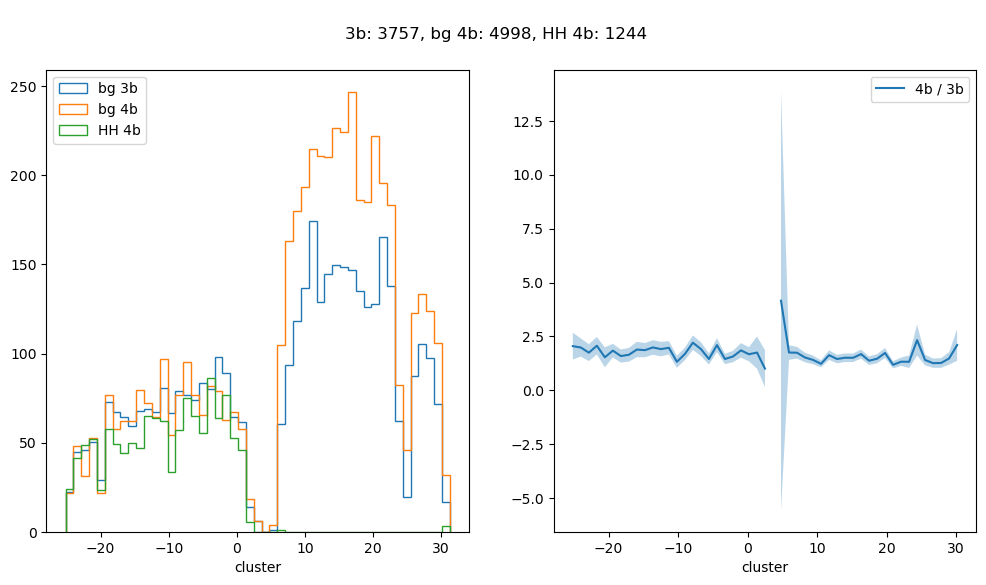

In [164]:
import pytorch_lightning as pl
from torch.utils.data import TensorDataset
from fvt_classifier import FvTClassifier
from fvt_representations import get_fvt_reprs
from plots import plot_cluster

np.random.seed(seed_)

features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

pl.seed_everything(seed_)
np.random.seed(seed_)

test_ratio = 0.5
n_3b = 250000
n_all4b = 250000
signal_ratio = 0.05
probs_4b_threshold = 0.6


print("********************************************")
print(f"Signal ratio: {signal_ratio}")
print(f"Threshold: {probs_4b_threshold}")
print("********************************************")


n_3b_train = int(n_3b * (1 - test_ratio))
n_all4b_train = int(n_all4b * (1 - test_ratio))
n_bg4b_train = n_all4b_train - int(n_all4b_train * signal_ratio)
n_hh4b_train = int(n_all4b_train * signal_ratio)


df_3b_train = df_3b.iloc[:n_3b_train]
df_bg4b_train = df_bg4b.iloc[:n_bg4b_train]
df_hh4b_train = df_hh4b.iloc[:n_hh4b_train]
# reweight to match signal_ratio
df_hh4b_train.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_train["weight"]) / np.sum(df_hh4b_train["weight"])) * df_hh4b_train["weight"]
df_train = pd.concat([df_3b_train, df_bg4b_train, df_hh4b_train])
# shuffle the data
df_train = df_train.sample(frac=1, random_state=seed_).reset_index(drop=True)

n_3b_test = n_3b - n_3b_train
n_all4b_test = n_all4b - n_all4b_train
n_bg4b_test = n_all4b_test - int(n_all4b_test * signal_ratio)
n_hh4b_test = int(n_all4b_test * signal_ratio)

df_3b_test = df_3b.iloc[n_3b_train:n_3b_train+n_3b_test]
df_bg4b_test = df_bg4b.iloc[n_bg4b_train:n_bg4b_train+n_bg4b_test]
df_hh4b_test = df_hh4b.iloc[n_hh4b_train:n_hh4b_train+n_hh4b_test]
df_hh4b_test.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_test["weight"]) / np.sum(df_hh4b_test["weight"])) * df_hh4b_test["weight"]
df_test = pd.concat([df_3b_test, df_bg4b_test, df_hh4b_test])
df_test = df_test.sample(frac=1, random_state=seed_).reset_index(drop=True)

# For ghostbatch, let len(train_indices) be a multiple of 32
split_at = 1024 * (int((2/3) * df_train.index.size) // 1024)
end_at = 1024 * (df_train.index.size // 1024)

X_train = torch.tensor(df_train[features].values, dtype=torch.float32)[:split_at]
w_train = torch.tensor(df_train["weight"].values, dtype=torch.float32)[:split_at]
y_train = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[:split_at]
is_signal_train = torch.tensor(df_train["signal"].values, dtype=torch.long)[:split_at]

X_val = torch.tensor(df_train[features].values, dtype=torch.float32)[split_at:end_at]
w_val = torch.tensor(df_train["weight"].values, dtype=torch.float32)[split_at:end_at]
y_val = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[split_at:end_at]
is_signal_val = torch.tensor(df_train["signal"].values, dtype=torch.long)[split_at:end_at]

train_dataset = TensorDataset(X_train, y_train, w_train)
val_dataset = TensorDataset(X_val, y_val, w_val)

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 30
run_name = "_".join(["fvt_classifier_toy_signal_ratio", 
                    f"signal_ratio={signal_ratio}", 
                    f"dijet={dim_dijet_features}", 
                    f"quadjet={dim_quadjet_features}", 
                    f"n_3b={n_3b}",
                    f"n_all4b={n_all4b}",])
lr = 1e-3

end_at = 1024 * (df_test.index.size // 1024)

X_test = torch.tensor(df_test[features].values[:end_at], dtype=torch.float32)
w_test = torch.tensor(df_test["weight"].values[:end_at], dtype=torch.float32)
y_test = torch.tensor(df_test["fourTag"].values[:end_at], dtype=torch.long)
is_signal_test = torch.tensor(df_test["signal"].values[:end_at], dtype=torch.long)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
q_repr_test, view_scores_test = get_fvt_reprs(X_test, fvt_model)
labels_4b_test = y_test.cpu().numpy()
probs_4b_test = fvt_model.predict(X_test)[:, 1].cpu().numpy()
weights_test = w_test.cpu().numpy()
is_signal_test = is_signal_test.cpu().numpy()
is_3b_test = labels_4b_test == 0
is_4b_test = labels_4b_test == 1
is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)

# umap

import umap

n_components = 1
umap_reducer = umap.UMAP(n_components=n_components, 
                        #  random_state=seed_, 
                            verbose=False)
reducer = umap_reducer

probs_4b_exceeded = probs_4b_test > probs_4b_threshold
n_exceeded = np.sum(probs_4b_exceeded)

n_points = min(np.sum(probs_4b_exceeded), 10000)
n_cluster_3b = np.sum(is_3b_test & probs_4b_exceeded)
n_cluster_bg4b = np.sum(is_bg4b_test & probs_4b_exceeded)
n_cluster_hh4b = np.sum(is_hh4b_test & probs_4b_exceeded)

n_cluster_3b = int((n_points / n_exceeded) * n_cluster_3b)
n_cluster_bg4b = int((n_points / n_exceeded) * n_cluster_bg4b)
n_cluster_hh4b = int((n_points / n_exceeded) * n_cluster_hh4b)

np.random.seed(seed_)

cluster_samples = np.concatenate([
    np.random.choice(np.where(is_3b_test & probs_4b_exceeded)[0], n_cluster_3b, replace=False),
    np.random.choice(np.where(is_bg4b_test & probs_4b_exceeded)[0], n_cluster_bg4b, replace=False),
    np.random.choice(np.where(is_hh4b_test & probs_4b_exceeded)[0], n_cluster_hh4b, replace=False),
])
q_repr_cluster = q_repr_test[cluster_samples]
is_3b_cluster = labels_4b_test[cluster_samples] == 0
is_bg4b_cluster = (labels_4b_test[cluster_samples] == 1) & (is_signal_test[cluster_samples] == 0)
is_hh4b_cluster = is_signal_test[cluster_samples] == 1
weights_cluster = weights_test[cluster_samples]
view_scores_cluster = view_scores_test[cluster_samples]

att_q_repr_cluster = (q_repr_cluster @ view_scores_cluster[:, :, None]).reshape(-1, dim_quadjet_features)
umap_embed_cluster = reducer.fit_transform(att_q_repr_cluster)

plot_cluster(umap_embed_cluster, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)

In [165]:
att_q_repr_test = (q_repr_test @ view_scores_test[:, :, None]).reshape(-1, dim_quadjet_features)
umap_embed_test = umap_reducer.transform(att_q_repr_test)

# Background region:  125749
# Signal region:  124107
Percentage of signal in the signal region / total signals:  0.97904


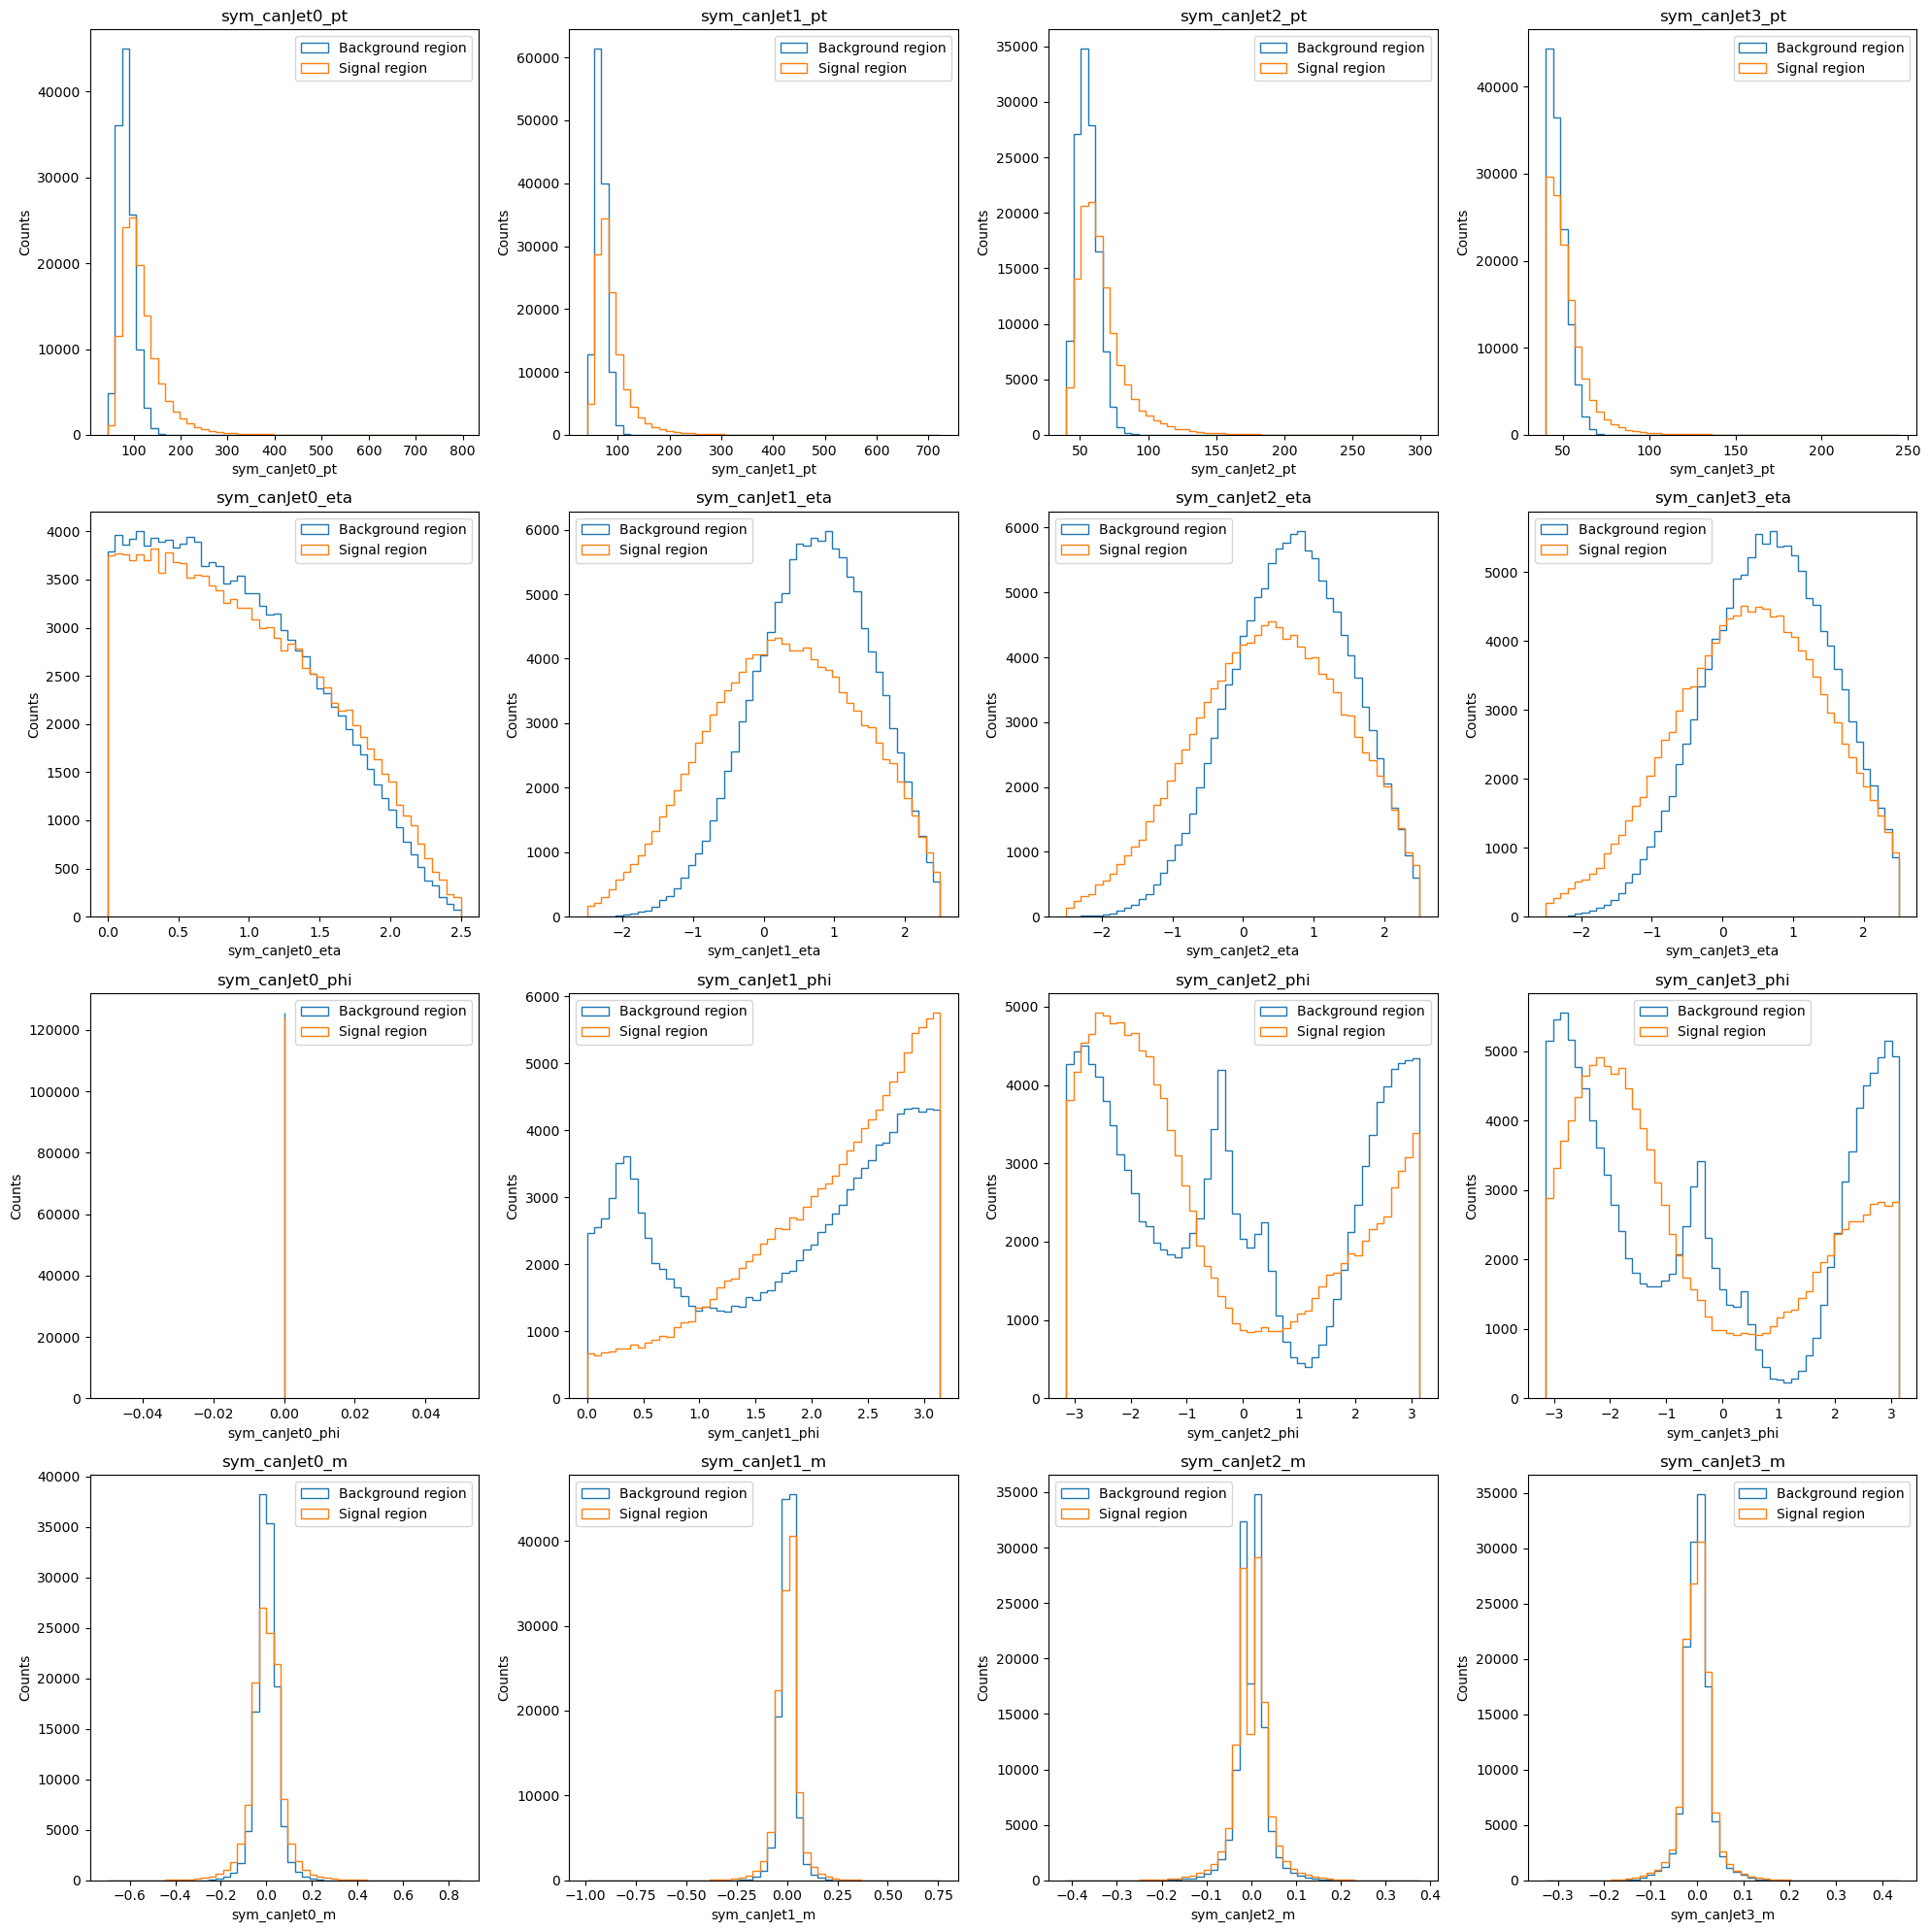

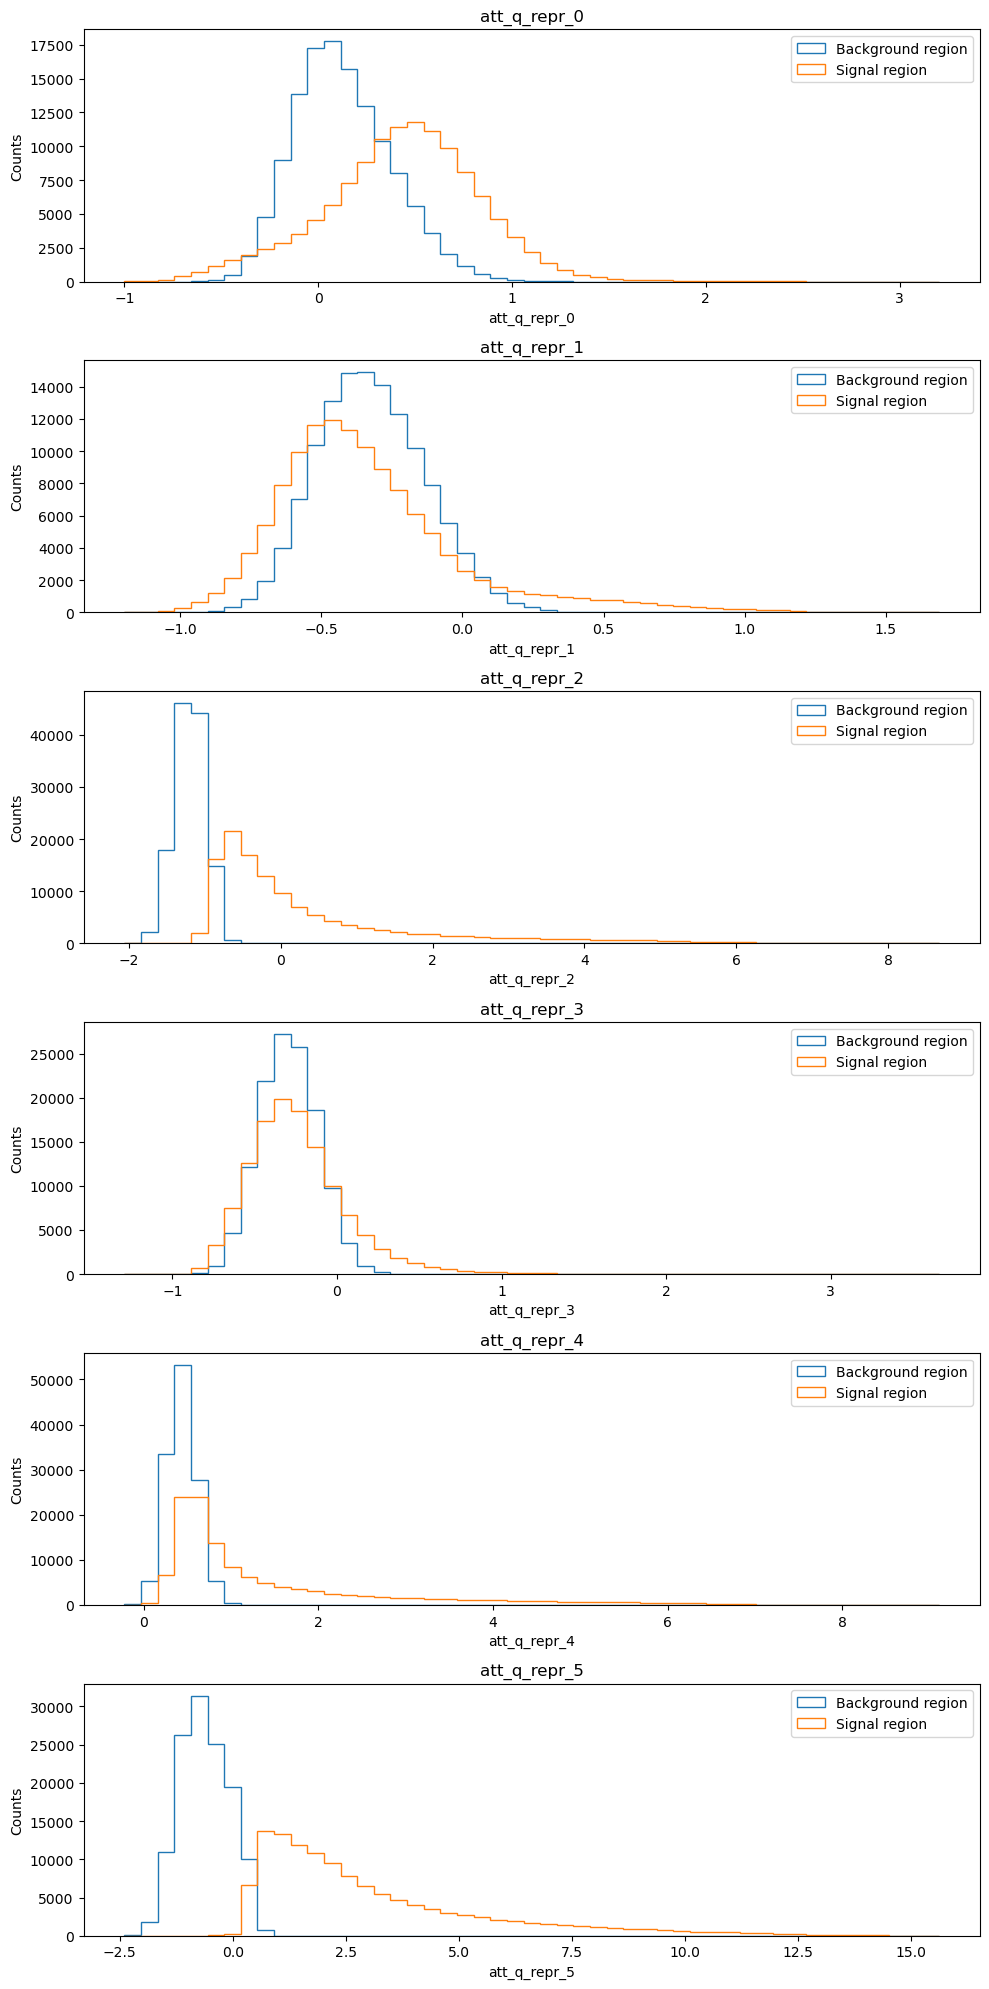

Sideband
3b:  56666.773
bg4b:  66572.96
hh4b:  151.80278
Signal Region
3b:  tensor(69798.5156)
bg4b:  tensor(53139.9453)
hh4b:  tensor(6149.4131)


/tmp/ipykernel_220516/1366521981.py:189: RuntimeWarning: invalid value encountered in divide
  ax[1].plot((bins_range[1:] + bins_range[:-1]) / 2, hist_bg4b / hist_3b, "o-", label="bg4b/3b")
/tmp/ipykernel_220516/1366521981.py:190: RuntimeWarning: invalid value encountered in divide
  ax[1].plot((bins_range[1:] + bins_range[:-1]) / 2, hist_bg4b / hist_rwsb3b, "o-", label="bg4b/SB reweighted 3b")
/tmp/ipykernel_220516/1366521981.py:191: RuntimeWarning: invalid value encountered in divide
  ax[1].plot((bins_range[1:] + bins_range[:-1]) / 2, hist_bg4b / hist_rwfvt3b, "o-", label="bg4b/FvT reweighted 3b")


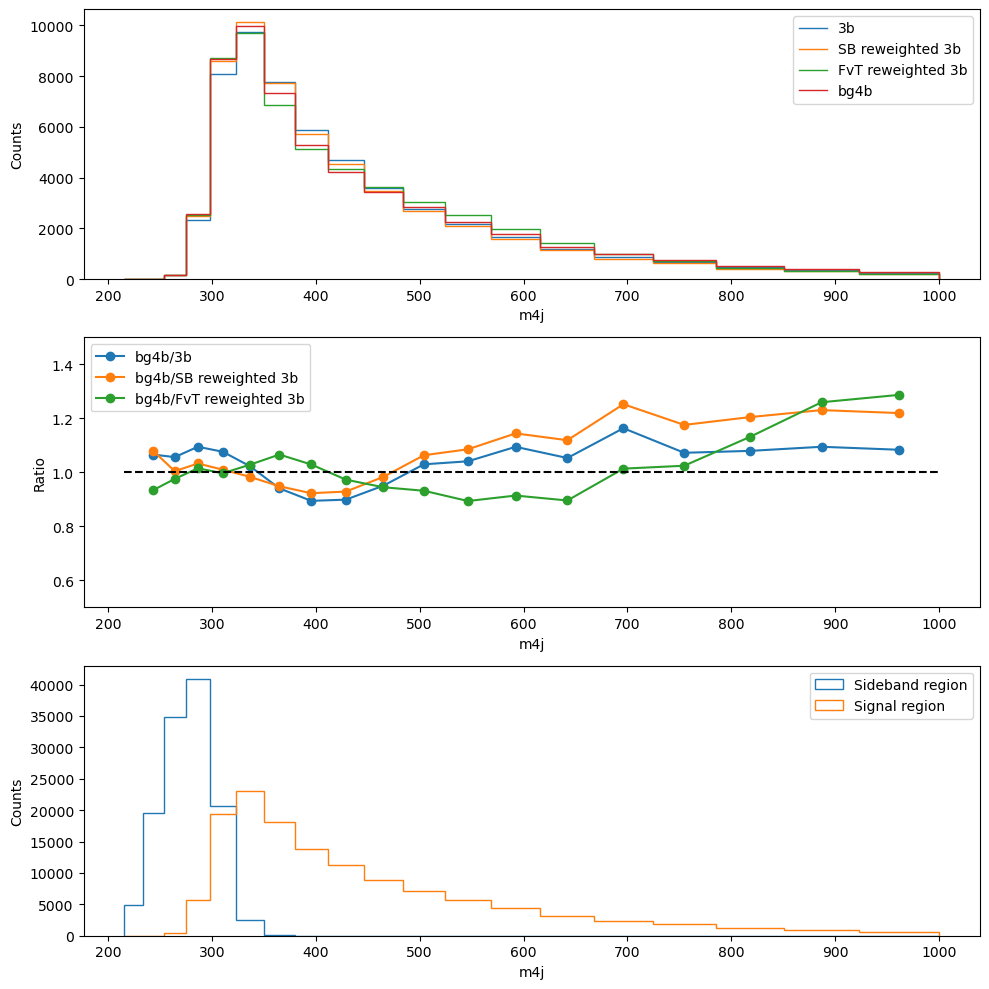

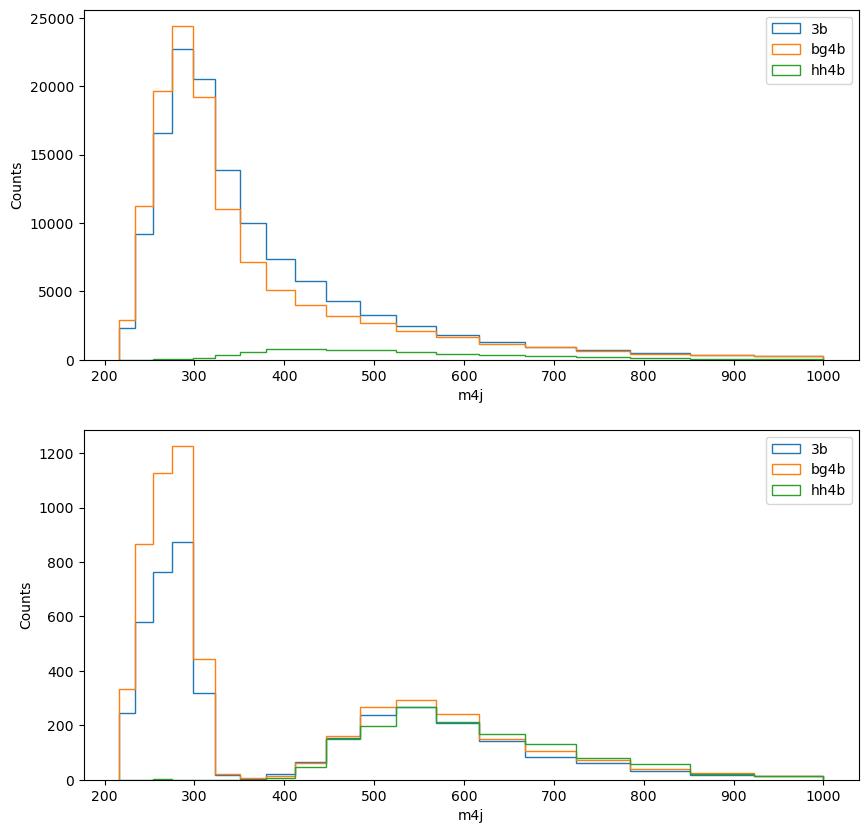

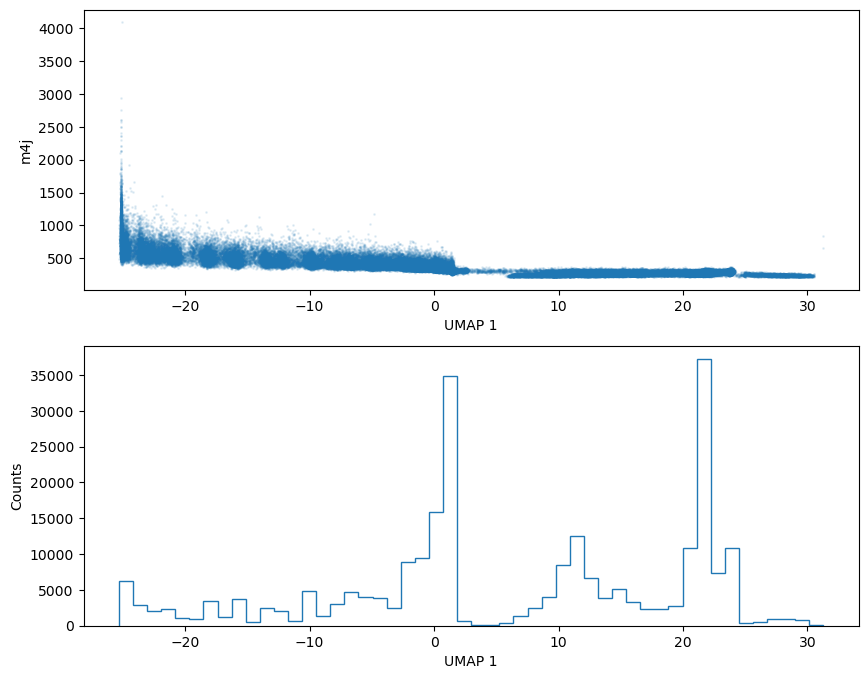

In [191]:
# Train a FvT with Background samples
from fvt_classifier import FvTClassifier

train_sb = False
umap_sr_filter = (5, "below")
is_in_sr = umap_embed_test[:, 0] < umap_sr_filter[0] if umap_sr_filter[1] == "below" else umap_embed_test[:, 0] > umap_sr_filter[0]

# umap_sr_filter = ("-10_0", "below_and_above")
# is_in_sr = (umap_embed_test[:, 0] > -10) & (umap_embed_test[:, 0] < 0)
# plot X_test in the original space

print("# Background region: ", np.sum(~is_in_sr))
print("# Signal region: ", np.sum(is_in_sr))
print("Percentage of signal in the signal region / total signals: ", np.sum(is_signal_test[is_in_sr]) / np.sum(is_signal_test))

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
for idx, feature in enumerate(features):
    bins_range = np.linspace(X_test[:, idx].min(), X_test[:, idx].max(), 50)
    current_ax = ax[idx // 4, idx % 4]    
    current_ax.hist(X_test[~is_in_sr, idx].cpu().numpy(), bins=bins_range, histtype="step", label="Background region")
    current_ax.hist(X_test[is_in_sr, idx].cpu().numpy(), bins=bins_range, histtype="step", label="Signal region")
    current_ax.set_xlabel(feature)
    current_ax.set_ylabel("Counts")
    current_ax.legend()
    current_ax.set_title(feature)

plt.tight_layout()
plt.show()
plt.close()

fig, ax = plt.subplots(nrows=dim_quadjet_features, ncols=1, figsize=(10, 20))
for idx in range(dim_quadjet_features):
    bins_range = np.linspace(att_q_repr_test[:, idx].min(), att_q_repr_test[:, idx].max(), 50)
    current_ax = ax[idx]
    current_ax.hist(att_q_repr_test[~is_in_sr, idx], bins=bins_range, histtype="step", label="Background region")
    current_ax.hist(att_q_repr_test[is_in_sr, idx], bins=bins_range, histtype="step", label="Signal region")
    current_ax.set_xlabel(f"att_q_repr_{idx}")
    current_ax.set_ylabel("Counts")
    current_ax.legend()
    current_ax.set_title(f"att_q_repr_{idx}")

plt.tight_layout()
plt.show()
plt.close()

sb_run_name = "_".join([run_name, f"threshold={probs_4b_threshold}", f"umap_sr_filter={umap_sr_filter[0]}_{umap_sr_filter[1]}", "sb"])

X_sb = X_test[~is_in_sr]
w_sb = w_test[~is_in_sr]
y_sb = y_test[~is_in_sr]

split_at = 1024 * (int((2/3) * X_sb.size(0)) // 1024)
end_at = 1024 * (X_sb.size(0) // 1024)

X_sb_train = X_sb[:split_at]
w_sb_train = w_sb[:split_at]
y_sb_train = y_sb[:split_at]

X_sb_val = X_sb[split_at:end_at]
w_sb_val = w_sb[split_at:end_at]
y_sb_val = y_sb[split_at:end_at]

sb_train_dataset = TensorDataset(X_sb_train, y_sb_train, w_sb_train)
sb_val_dataset = TensorDataset(X_sb_val, y_sb_val, w_sb_val)

# Train SB FvT 

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 30
lr = 1e-3

if train_sb:
    pl.seed_everything(42)

    sb_model = FvTClassifier(num_classes, 
                        dim_input_jet_features, 
                        dim_dijet_features, 
                        dim_quadjet_features, 
                        run_name=sb_run_name,
                        device=torch.device("cuda:0"),
                        lr=lr)

    sb_model.fit(sb_train_dataset, sb_val_dataset, batch_size=1024, max_epochs=max_epochs)

sb_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{sb_run_name}_best.ckpt")
q_repr_sb_val = get_fvt_reprs(X_sb_val, sb_model)[0]
q_repr_sb_val = np.concatenate(q_repr_sb_val, axis=0)
labels_4b_sb_val = y_sb_val.cpu().numpy()
probs_4b_sb_val = sb_model.predict(X_sb_val)[:, 1].cpu().numpy()
weights_sb_val = w_sb_val.cpu().numpy()

# from plots import plot_prob_weighted_histogram1d, calibration_plot

# plot_prob_weighted_histogram1d(probs_4b_sb_val, 
#                                probs_4b_sb_val, 
#                                labels_4b_sb_val,
#                                n_bins=50, 
#                                sample_weights=weights_sb_val,
#                                ylim=(0.5, 1.5))
# calibration_plot(probs_4b_sb_val, labels_4b_sb_val,
#                  bins=50,
#                  sample_weights=weights_sb_val)

is_3b_sb = is_3b_test[~is_in_sr]
is_bg4b_sb = is_bg4b_test[~is_in_sr]
is_hh4b_sb = is_hh4b_test[~is_in_sr]
weights_sb = weights_test[~is_in_sr]

# weight of 3b, bg4b, hh4b

print("Sideband")
print("3b: ", np.sum(weights_sb[is_3b_sb]))
print("bg4b: ", np.sum(weights_sb[is_bg4b_sb]))
print("hh4b: ", np.sum(weights_sb[is_hh4b_sb]))

X_sr = X_test[is_in_sr]
is_3b_sr = is_3b_test[is_in_sr]
is_4b_sr = is_4b_test[is_in_sr]
is_bg4b_sr = is_bg4b_test[is_in_sr]
is_hh4b_sr = is_hh4b_test[is_in_sr]
weights_sr = w_test[is_in_sr]

end_at = 1024 * (X_sr.size(0) // 1024)
X_sr = X_sr[:end_at]
is_3b_sr = is_3b_sr[:end_at]
is_4b_sr = is_4b_sr[:end_at]
is_bg4b_sr = is_bg4b_sr[:end_at]
is_hh4b_sr = is_hh4b_sr[:end_at]
weights_sr = weights_sr[:end_at]

# calculate m4j

from ancillary_features import get_m4j

m4j_sb = get_m4j(X_sb)
m4j_sr = get_m4j(X_sr)

# plot histograms of m4j

# print weights of 3b, bg4b, hh4b

print("Signal Region")
print("3b: ", torch.sum(weights_sr[is_3b_sr]))
print("bg4b: ", torch.sum(weights_sr[is_bg4b_sr]))
print("hh4b: ", torch.sum(weights_sr[is_hh4b_sr]))

probs_4b_sb_sr = sb_model.predict(X_sr)[:, 1].cpu().numpy()
probs_4b_fvt_sr = fvt_model.predict(X_sr)[:, 1].cpu().numpy()

# reweight 3b samples by probs_4b_sb_sr / (1 - probs_4b_sb_sr)

weights_sr = weights_sr.cpu().numpy()
reweights_sb_sr = np.where(is_3b_sr, weights_sr * (probs_4b_sb_sr / (1 - probs_4b_sb_sr)), weights_sr)
reweights_fvt_sr = np.where(is_3b_sr, weights_sr * (probs_4b_fvt_sr / (1 - probs_4b_fvt_sr)), weights_sr)

# histogram of m4j

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
# bins to be a geometric sequence
# bins_range = np.geomspace(m4j_sr.min(), m4j_sr.max(), 40)
bins_range = np.geomspace(min(m4j_sr.min(), m4j_sb.min()), 1000, 20)
hist_3b, _ = np.histogram(m4j_sr[is_3b_sr], bins=bins_range, weights=weights_sr[is_3b_sr])
hist_rwsb3b, _ = np.histogram(m4j_sr[is_3b_sr], bins=bins_range, weights=reweights_sb_sr[is_3b_sr])
hist_rwfvt3b, _ = np.histogram(m4j_sr[is_3b_sr], bins=bins_range, weights=reweights_fvt_sr[is_3b_sr])
hist_bg4b, _ = np.histogram(m4j_sr[is_bg4b_sr], bins=bins_range, weights=weights_sr[is_bg4b_sr])

# normalize the histograms
hist_3b = hist_3b * (np.sum(hist_bg4b) / np.sum(hist_3b))
hist_rwsb3b = hist_rwsb3b * (np.sum(hist_bg4b) / np.sum(hist_rwsb3b))
hist_rwfvt3b = hist_rwfvt3b * (np.sum(hist_bg4b) / np.sum(hist_rwfvt3b))
# hist_bg4b = hist_bg4b 


ax[0].stairs(hist_3b, bins_range, label="3b")
ax[0].stairs(hist_rwsb3b, bins_range, label="SB reweighted 3b")
ax[0].stairs(hist_rwfvt3b, bins_range, label="FvT reweighted 3b")
ax[0].stairs(hist_bg4b, bins_range, label="bg4b")
ax[0].set_xlabel("m4j")
ax[0].set_ylabel("Counts")
ax[0].legend()

err_3b = np.sqrt(hist_3b)
err_rw3b = np.sqrt(hist_rwsb3b)
# ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, hist_bg4b / hist_3b , yerr=err_3b / hist_bg4b, fmt="o-", label="bg4b/3b")
# ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, hist_bg4b / hist_rwsb3b, yerr=err_rw3b / hist_bg4b, fmt="o-", label="SB reweighted bg4b/3b")
ax[1].plot((bins_range[1:] + bins_range[:-1]) / 2, hist_bg4b / hist_3b, "o-", label="bg4b/3b")
ax[1].plot((bins_range[1:] + bins_range[:-1]) / 2, hist_bg4b / hist_rwsb3b, "o-", label="bg4b/SB reweighted 3b")
ax[1].plot((bins_range[1:] + bins_range[:-1]) / 2, hist_bg4b / hist_rwfvt3b, "o-", label="bg4b/FvT reweighted 3b")
ax[1].hlines(1, bins_range[0], bins_range[-1], color="black", linestyle="--")
ax[1].set_ylim(0.5, 1.5)
ax[1].set_xlabel("m4j")
ax[1].set_ylabel("Ratio")
ax[1].legend()

ax[2].hist(m4j_sb, bins=bins_range, weights=weights_sb, histtype="step", label="Sideband region")
ax[2].hist(m4j_sr, bins=bins_range, weights=weights_sr, histtype="step", label="Signal region")
ax[2].set_xlabel("m4j")
ax[2].set_ylabel("Counts")
ax[2].legend()

plt.tight_layout()
plt.show()

m4j_test = get_m4j(X_test)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
bins_range = np.geomspace(m4j_test.min(), 1000, 20)

ax[0].hist(m4j_test[is_3b_test], bins=bins_range, histtype="step", label="3b")
ax[0].hist(m4j_test[is_bg4b_test], bins=bins_range, histtype="step", label="bg4b")
ax[0].hist(m4j_test[is_hh4b_test], bins=bins_range, histtype="step", label="hh4b")
ax[0].set_xlabel("m4j")
ax[0].set_ylabel("Counts")
ax[0].legend()

ax[1].hist(m4j_test[is_3b_test & probs_4b_exceeded], bins=bins_range, histtype="step", label="3b")
ax[1].hist(m4j_test[is_bg4b_test & probs_4b_exceeded], bins=bins_range, histtype="step", label="bg4b")
ax[1].hist(m4j_test[is_hh4b_test & probs_4b_exceeded], bins=bins_range, histtype="step", label="hh4b")
ax[1].set_xlabel("m4j")
ax[1].set_ylabel("Counts")
ax[1].legend()


# ax[1].hist(m4j_test[~is_in_sr], bins=bins_range, histtype="step", label="Sideband region")
# ax[1].hist(m4j_test[is_in_sr], bins=bins_range, histtype="step", label="Signal region")
# ax[1].set_ylabel("Counts")
# ax[1].legend()


plt.show()
plt.close()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax[0].plot(umap_embed_test[:, 0], m4j_test, "o", markersize=1, alpha=0.1)
ax[0].set_xlabel("UMAP 1")
ax[0].set_ylabel("m4j")

ax[1].hist(umap_embed_test[:, 0], bins=50, histtype="step")
ax[1].set_xlabel("UMAP 1")
ax[1].set_ylabel("Counts")

plt.show()
plt.close()